In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
# Load data
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [11]:
# Convert data to numpy arrays
train_data = np.array(train_data)
test_data = np.array(test_data)

In [12]:
# Shuffle training data
np.random.shuffle(train_data)

# Split training data into features and targets
train_features = train_data[:, 1:]
train_targets = train_data[:, 0]

# Normalize inputs from 0-255 to 0-1
train_features = train_features / 255.0 
test_features = test_data / 255.0

# Reshape features
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

In [13]:
# Split the training data into training and validation sets manually
split_ratio = 0.8
split_index = int(train_features.shape[0] * split_ratio)

x_train = train_features[:split_index]
y_train = train_targets[:split_index]
X_val = train_features[split_index:]
y_val = train_targets[split_index:]

x_test = test_features  # Features from test.csv

print(train_features.shape)
print(test_features.shape)

(42000, 784)
(28000, 784)


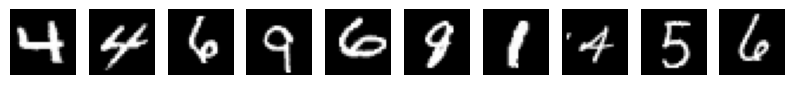

Labels for each of the above images, respectively: [4 4 6 9 6 8 1 4 5 6]


In [14]:
# Visualizing the first 10 images in the dataset and their labels
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap="gray")
    plt.axis('off')
plt.show()
print('Labels for each of the above images, respectively: %s' % (y_train[0:10]))

In [15]:
# Linear layer class
class Linear():
    def __init__(self, in_size, out_size):
        self.w = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.w, self.b]
        self.grad_w = None
        self.grad_b = None
        self.grad_input = None
    
    def forward(self, x):
        self.x = x
        self.output = np.dot(x, self.w) + self.b
        return self.output
    
    def backward(self, next_grad):
        self.grad_w = np.dot(self.x.T, next_grad)
        self.grad_b = np.sum(next_grad, axis=0)
        self.grad_input = np.dot(next_grad, self.w.T)
        return self.grad_input, [self.grad_w, self.grad_b]

In [16]:
# ReLU activation
class Relu():
    def __init__(self):
        self.params = []
        self.grad_input = None
    
    def forward(self, x):
        self.output = np.maximum(x, 0)
        return self.output
        
    def backward(self, next_grad):
        self.grad_input = next_grad.copy()
        self.grad_input[self.output <= 0] = 0
        return self.grad_input, []

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    out = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return out

In [17]:
# Cross-entropy loss
class CrossEntropy:
    def forward(self, x, y):
        self.m = y.shape[0]
        self.p = softmax(x)
        cross_entropy = -np.log(self.p[range(self.m), y])
        loss = np.sum(cross_entropy) / self.m
        return loss
        
    def backward(self, x, y):
        grad = self.p.copy()
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad


In [18]:
# Neural Network class
class NN():
    def __init__(self, lossfunc=CrossEntropy()):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, next_grad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            next_grad, grad = layer.backward(next_grad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, x, y):
        out = self.forward(x)
        loss = self.loss_func.forward(out, y)
        next_grad = self.loss_func.backward(out, y)
        self.backward(next_grad)
        return loss
    
    def predict(self, x):
        x = self.forward(x)
        return np.argmax(x, axis=1)
    
    def clear_grad_param(self):
        self.grads = []


In [19]:
# Parameter update function
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]


In [20]:
# Minibatch function
def minibatch(x, y, minibatch_size):
    n = x.shape[0]
    minibatches = []
    permutation = np.random.permutation(n)
    x = x[permutation]
    y = y[permutation]
    
    for i in range(0, n, minibatch_size):
        x_batch = x[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size]
        minibatches.append((x_batch, y_batch))
        
    return minibatches

In [21]:
# Training Loop
def train(net, x_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):
    val_loss_epoch = []
    minibatches = minibatch(x_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        for x_mini, y_mini in minibatches:
            loss = net.train_step(x_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, net.grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss = net.train_step(X_mini_val, y_mini_val)
            val_loss_batch.append(val_loss)
            
        if i % 10 == 0 or i == epoch - 1:
            m_train = x_train.shape[0]
            m_val = X_val.shape[0]
            y_train_pred = np.array([], dtype="int64")
            y_val_pred = np.array([], dtype="int64")
            y_train1 = []
            y_vall = []
            for j in range(0, m_train, minibatch_size):
                x_tr = x_train[j:j + minibatch_size, :]
                y_tr = y_train[j:j + minibatch_size]
                y_train1 = np.append(y_train1, y_tr)
                y_train_pred = np.append(y_train_pred, net.predict(x_tr))

            for j in range(0, m_val, minibatch_size):
                x_va = X_val[j:j + minibatch_size, :]
                y_va = y_val[j:j + minibatch_size]
                y_vall = np.append(y_vall, y_va)
                y_val_pred = np.append(y_val_pred, net.predict(x_va))
            
            train_acc = check_accuracy(y_train1, y_train_pred)
            val_acc = check_accuracy(y_vall, y_val_pred)

            mean_train_loss = sum(loss_batch) / float(len(loss_batch))
            mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
            
            val_loss_epoch.append(mean_val_loss)
            print(f"Epoch {i}: Loss = {mean_train_loss:.4f} | Training Accuracy = {train_acc:.4f} | Val Loss = {mean_val_loss:.4f} | Val Accuracy = {val_acc:.4f}")

    return net

In [22]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

# Setting random seed for reproducibility
np.random.seed(3)

# Input size
input_dim = x_train.shape[1]

# Hyperparameters
iterations = 10
learning_rate = 0.11
hidden_nodes = 32
output_nodes = 10

In [23]:
# Define neural network
nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(Relu())
nn.add_layer(Linear(hidden_nodes, output_nodes))

# Train the model
nn = train(nn, x_train, y_train, minibatch_size=200, epoch=50, learning_rate=learning_rate, X_val=X_val, y_val=y_val)


Epoch 0: Loss = 0.6547 | Training Accuracy = 0.9299 | Val Loss = 0.2738 | Val Accuracy = 0.9194
Epoch 10: Loss = 0.0684 | Training Accuracy = 0.9783 | Val Loss = 0.1653 | Val Accuracy = 0.9542
Epoch 20: Loss = 0.0393 | Training Accuracy = 0.9832 | Val Loss = 0.2071 | Val Accuracy = 0.9548
Epoch 30: Loss = 0.0165 | Training Accuracy = 0.9890 | Val Loss = 0.2308 | Val Accuracy = 0.9546
Epoch 40: Loss = 0.0059 | Training Accuracy = 0.9975 | Val Loss = 0.2378 | Val Accuracy = 0.9582
Epoch 49: Loss = 0.0028 | Training Accuracy = 0.9991 | Val Loss = 0.2444 | Val Accuracy = 0.9593


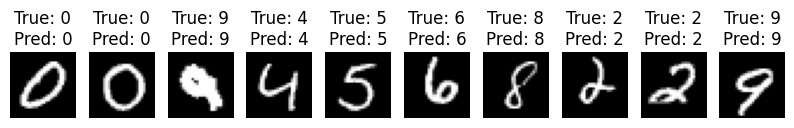

In [26]:
# Compare a few images with the guesses from the trained model
plt.figure(figsize=(10, 2))
for i in range(10):
    index = np.random.randint(0, X_val.shape[0])
    img = X_val[index].reshape(28, 28)
    true_label = y_val[index]
    predicted_label = nn.predict(X_val[index].reshape(1, -1))[0]
    
    plt.subplot(1, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {true_label}\nPred: {predicted_label}')
    plt.axis('off')
plt.show()